<h1> Detección oportuna de neumonía usando radiografías de tórax </h1>
<h2> Integrantes del equipo </h2><ul>
    <li> <h3>Oscar David Zendejas Rangel, 313439, od.zendejasrangel@ugto.mx </h3></li>
    <li> <h3>Luis Angel Celedón Oros, NUA, @ugto.mx </h3></li></ul>

# Importación de librerías.
Comenzamos nombrando las librerías básicas que usaremos. Las cuales son base fundamental para que funcione el script. Posteriormente importamos librerías para poder trabajar con las imagenes y poder descargar el archivo .zip (Esto sólo será una vez, pues una vez cargados los guardamos como arreglos de numpy y posteriormente podemos acceder a ellos solamente cargandolos). 
Luego, usamos la librería imb para hacer muestreo.
Las librerías tqdm y datetime son meramente auxiliares.

In [ ]:
#from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from glob import glob
import shutil
import zipfile

#para redimencionar
import sklearn
import skimage
from skimage.transform import resize
import random
#Usaremos datetime para nombrar archivos
import datetime
from tqdm import tqdm #barra de progreso`
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Las dos celdas de abajo, permiten vincular tu cuenta de Google para que puedas acceder a tu Drive. La estructura debes revisarla de acuerdo a las organizaciones de tus carpetas. A partir de 'My Drive' sigue la ubicación de la carpeta y el nombre de donde se encuentran los archivos. Posteriormente, todo sigue igual. Aunque para leer los numpys arrays se tiene que seguir la misma estructura a lo que hacemos ahora.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
#Extracción de la base de datos
local_zip = '/content/drive/My Drive/ProyectoFinal_ML/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()
'''

# Carga de Datos
Usamos los accesos dentro de la carpeta de Drive a la cual ya tenemos acceso. Sólo necesitamos darle la dirección de la carpeta y posteriormente cargamos los archivos mediante la dirección proporcionada.
Tenemos una variable booleana que nos permite saber si vamos a cargar por primera vez los archivos o si ya tenemos los arreglos de numpy. Como las imagenes ya fueron cargadas con antelación está marcada como False. Esto nos ahorra muchísimo tiempo y computo.

In [ ]:
# Carpeta donde se almacena la base de datos descargada
base_dir = '/content/drive/My Drive/ProyectoFinal_ML/chest_xray'

# Carpetas donde se almacenan los conjuntos de entrenamiento y validación
# '/content/drive/My Drive/CNNs/ProyectoFinal_ML/train'
train_dir = os.path.join(base_dir,'train/') 
validation_dir = os.path.join(base_dir,'val/') 
test_dir=os.path.join(base_dir,'test/')


#X = os.path.join(direction, 'PNEUMONIA') ; y = os.path.join(direction, 'NORMAL')
#X = np.asarray(X) ; y = np.asarray(y)
LOAD_FROM_IMAGES = False
def get_data(folder):
    X = [] ; y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
                    img_file = rgb2gray(img_file)
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    return X,y


if LOAD_FROM_IMAGES:
    #cargamos las imágenes a los arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    X_val, y_val = get_data(validation_dir)

    #grabamos los arrays en archivos
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', y_test)
    np.save('xval,npy', X_val)
    np.save('yval.npy', y_val)
else:
    #cargamos los arrays anteriormente grabados
    X_train = np.load('/content/drive/My Drive/ProyectoFinal_ML/xtrain.npy')
    y_train = np.load('/content/drive/My Drive/ProyectoFinal_ML/ytrain.npy')
    X_test = np.load('/content/drive/My Drive/ProyectoFinal_ML/xtest.npy')
    y_test = np.load('/content/drive/My Drive/ProyectoFinal_ML/ytest.npy')
    X_val=np.load('/content/drive/My Drive/ProyectoFinal_ML/xval.npy')
    y_val=np.load('/content/drive/My Drive/ProyectoFinal_ML/yval.npy')

In [ ]:
X_val.shape

(16, 150, 150)

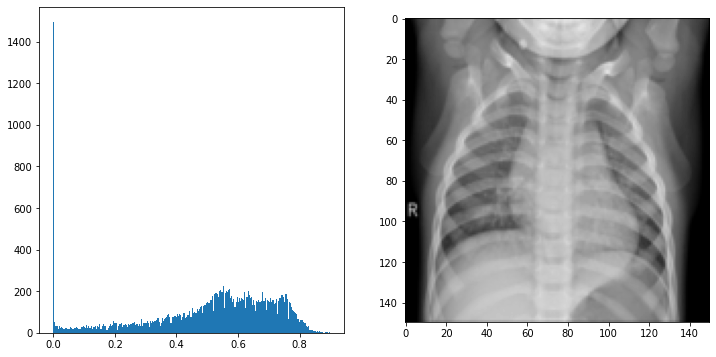

In [ ]:

def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.hist(a.ravel(), bins=255)
    plt.subplot(1, 2, 2)
    plt.imshow(a, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
plotHistogram(X_train[725])

# Tratamiento de la información

El problema que enfrentamos ahora es que para pasar los datos de input_shape a la capa de entrada no podemos manejar las imagenes como si tuvieran color, porque sólo las tenemos a blanco y negro. Entonces usamos el comando reshape para poder agregar una dimensión a cada fotografía.
Esto es, el shape original lo teníamos como (len(X_train),150,150) sin tomar en cuenta la dimensionalidad
Ahora, el nuevo shape es (len(X_train),150,150,1) De esta forma ya espcificamos una capa de color ByN.

Más adelante explicaremos que para el comparativo no pudimos agregar color al dataset original por problemas de dimensionalidad.

In [ ]:
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)
X_valReshaped = X_val.reshape(len(X_val), 150, 150, 1)

# Primera Arquitectura.
La siguiente imagen es meramente ilustrativa

In [ ]:
import requests
from ipywidgets import Image

Image(value=requests.get('https://es.mathworks.com/discovery/convolutional-neural-network-matlab/_jcr_content/mainParsys3/discoverysubsection_/mainParsys3/columns/b202664f-91e3-4c3e-8e3e-a299d0568e0b/image_copy.adapt.full.medium.jpg/1612358644015.jpg').content)


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x0…

La arquitectura de la red neuronal comienza al inicializar models.Sequential() para indicar que colocaremos una capa tras otra.

Comenzamos añadiendo la primera capa de convolución y la capa de entrada, que como mencionamos en la celda anterior tendrá de tamaño 150,150,1 como input_shape. En la primera capa de convolución tenemos 64 'cuadros' de 3x3 que serán los encargados de recorrer la imagen de entrada.

Posteriormente colocamos una capa de Pooling, pues ahora el recuadro se reduce a uno de 2x2.
Agregamos dos capas de igual configuración para tener un total de 3 capas de convolución y 3 capas de Pooling.

Luego de las capas de "Featuring Learning" aplanamos los vectores y entramos a la etapa de clasificación mediante una capa densa de 64 nodos y finalizamos con una capa de salida con una sola neurona. Claramente la salida es así porque sólo esperamos que sea un sí o un no.

Las funciones de activación que usamos en la etapa de feature learning es la función ReLu porque esta función trabaja muy bien con imágenes y al final usamos la función sigmoide porque ésta se activa o no se activa, es decir, trabaja de forma binaria, justo lo que necesitamos

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       2

Para compilar el modelo utilizamos el optimizador adam: este método es computacionalmente eficiente, requiere poca memoria, es invariante al reescalamiento de gradientes y se adapta muy bien a problemas que tienen información o parametros muy grandes, como nuestro caso que manejamos más de un millón de parámetros, todos entrenables.

Para el método de pérdida usamos binary_crossentropy puesto que tenemos dos clases y queremos representarla númericamente entre 0 y 1.

Como metricas medimos la precisión, la cual predice qué tan seguido las predicciones son iguales a las etiquetas originales.

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Entrenamiento del Modelo
Utilizamos varias épocas para el entrenamiento del modelo. Al final mostraremos una comparativa.

In [ ]:
history=model.fit(X_trainReshaped, y_train, epochs=12, validation_data = (X_valReshaped,y_val))

Epoch 1/12
84/84 [==============================] - 5s 53ms/step - loss: 0.0103 - accuracy: 0.9966 - val_loss: 0.0783 - val_accuracy: 0.9375
Epoch 2/12
84/84 [==============================] - 4s 52ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.0841 - val_accuracy: 0.9375
Epoch 3/12
84/84 [==============================] - 4s 53ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0475 - val_accuracy: 1.0000
Epoch 4/12
84/84 [==============================] - 4s 53ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 5/12
84/84 [==============================] - 4s 53ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.2200 - val_accuracy: 0.9375
Epoch 6/12
84/84 [==============================] - 4s 53ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.2642 - val_accuracy: 0.9375
Epoch 7/12
84/84 [==============================] - 4s 53ms/step - loss: 0.0084 - accuracy: 0.9955 - val_loss: 2.1759 - val_accuracy: 0.7500
Epoch 8/12
84

Evaluamos el modelo con el conjunto de prueba. Notamos que el conjunto de 

In [ ]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

20/20 [==============================] - 0s 19ms/step - loss: 2.1003 - accuracy: 0.7901
0.7900640964508057


In [ ]:
train_loss, train_acc = model.evaluate(X_trainReshaped, y_train)

84/84 [==============================] - 2s 18ms/step - loss: 0.0793 - accuracy: 0.9791


In [ ]:
#X_testReshaped[100][3]
test_predictions=model.predict(X_testReshaped)

In [ ]:
test_predictions=(test_predictions>0.8)

# Resultados de nuestro modelo.

Métricas en el conjunto de validación.

Pérdida mínima  0.04889724403619766  fue en la época 28
Mejor exactitud 1.0  fue en la época 28

Métricas en el conjunto de entrenamiento.

Pérdida mínima  0.005258417222648859  fue en la época 34
Mejor exactitud 0.9981357455253601  fue en la época 32


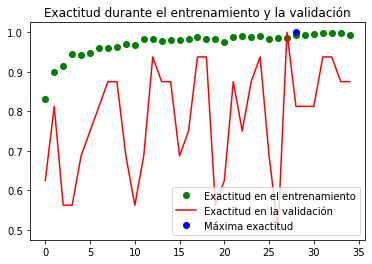

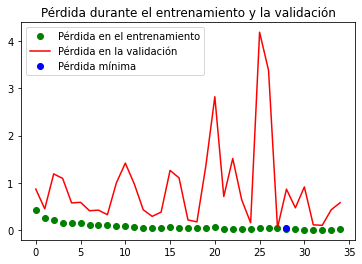

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Exactitud en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Exactitud en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Máxima exactitud')
plt.title('Exactitud durante el entrenamiento y la validación')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Pérdida mínima')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print('Métricas en el conjunto de validación.\n')
print('Pérdida mínima ', min_val_loss,' fue en la época',min_val_loss_epoch)
print('Mejor exactitud', max_val_acc,' fue en la época',max_val_acc_epoch)
print('\nMétricas en el conjunto de entrenamiento.\n')
print('Pérdida mínima ', min(loss),' fue en la época',loss.index(min(loss)) + 1)
print('Mejor exactitud', max(acc),' fue en la época',acc.index(max(acc)) + 1)

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_predictions)

In [ ]:
cm

array([[105, 129],
       [  6, 384]])

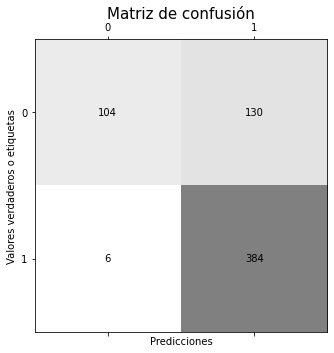

El accuracy obtenido en el conjunto de prueba fue de  0.7596153616905212


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Greys, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.title("Matriz de confusión", fontsize=15)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos o etiquetas')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()
print('El accuracy obtenido en el conjunto de prueba fue de ',test_acc)

# Comparación con modelo preentrenado VGG16
La importación se realiza desde keras. Usaremos las capas ya entrenadas con sus pesos porque esto nos ayuda a reconocer más de mil imagenes con las que fueron entrenadas las redes.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3)) # input_shape = (largo, ancho, canales) 72, 96

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Como les comentamos al principio del script, el problemas con estos modelos ya preentrenados es que se necesita forzosamente utilizar imagenes a color, nosotros planteamos usar las imagenes en escalas de grises para facilitar a nuestra arquitectura el reconocer blanco y negro. Para este caso entonces, desde la carga de datos solamente comentamos la línea que nos transforma las imagenes a escala de grises. Por lo tanto, creamos nuevos arreglos de numpy pero ahora con las imágenes a color. Los cuales cargamos en las siguientes líneas.

In [ ]:
    X_trainC = np.load('/content/drive/My Drive/ProyectoFinal_ML/xtrainc.npy')
    y_trainC = np.load('/content/drive/My Drive/ProyectoFinal_ML/ytrainc.npy')
    X_testC = np.load('/content/drive/My Drive/ProyectoFinal_ML/xtestc.npy')
    y_testC = np.load('/content/drive/My Drive/ProyectoFinal_ML/ytestc.npy')
    X_valC=np.load('/content/drive/My Drive/ProyectoFinal_ML/xvalc.npy')
    y_valC=np.load('/content/drive/My Drive/ProyectoFinal_ML/yvalc.npy')

In [ ]:
X_trainC.shape #Nos aseguramos de las dimensiones.

(2682, 150, 150, 3)

Creamos la arquitectura con la base ya preentrenada del modelo VGG16 y agregamos una capa de Pooling seguida de una de Normalización para los pesos, la cual consideramos muy importante meterla porque al tener demasiados parámetros seguramente alguno saldrá muy alto y de esta manera se estandarizan las unidades de pesos.

Posteriormente se realiza todo lo demás de manual, los aplanamos, agregamos una capa densa y ponemos una neurona de salida.

In [ ]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.BatchNormalization())
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

Lo siguiente es muy importantisimo, debido a la magnitud de las capas y a la riqueza de información que ya poseen los pesos del modelo, decidimos congelar las primeras cuatro capas del mismo. Esto nos ayuda a tener menos parámetros y a conservar la información de imagenet.

In [ ]:
for layer in conv_base.layers:
    if layer.name[:6] == 'block5': 
      layer.trainable = True
    else:
      layer.trainable = False

Compilamos con las mismas instrucciones que nuestro modelo y posteriormente lo entrenamos.

In [ ]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,847,937
Trainable params: 7,211,649
Non-trainable params: 7,636,288
___________________________________

In [ ]:
history2=model2.fit(X_trainC, y_trainC, epochs=12, validation_data = (X_valC,y_valC))

Epoch 1/12
84/84 [==============================] - 7s 83ms/step - loss: 2.7500e-06 - accuracy: 1.0000 - val_loss: 9.7116e-04 - val_accuracy: 1.0000
Epoch 2/12
84/84 [==============================] - 7s 84ms/step - loss: 3.3905e-06 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/12
84/84 [==============================] - 7s 85ms/step - loss: 2.4309e-06 - accuracy: 1.0000 - val_loss: 9.4638e-04 - val_accuracy: 1.0000
Epoch 4/12
84/84 [==============================] - 7s 86ms/step - loss: 1.6733e-06 - accuracy: 1.0000 - val_loss: 8.8191e-04 - val_accuracy: 1.0000
Epoch 5/12
84/84 [==============================] - 7s 86ms/step - loss: 2.2229e-06 - accuracy: 1.0000 - val_loss: 7.9952e-04 - val_accuracy: 1.0000
Epoch 6/12
84/84 [==============================] - 7s 85ms/step - loss: 2.6261e-06 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/12
84/84 [==============================] - 7s 83ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0

In [ ]:
test_loss2,test_acc2=model2.evaluate(X_testC,y_testC)
print(test_acc2)

20/20 [==============================] - 1s 68ms/step - loss: 1.1672 - accuracy: 0.8926
0.8926281929016113


In [ ]:
train_loss2,train_acc2=model2.evaluate(X_trainC,y_trainC)
print(train_acc2)

84/84 [==============================] - 6s 67ms/step - loss: 4.0357e-05 - accuracy: 1.0000
1.0


In [ ]:
test_predictions2=model2.predict(X_testC)
test_predictions2=(test_predictions2>0.8)

## Resultados del Modelo VGG16 con el dataset.

Métricas en el conjunto de validación.

Pérdida mínima  0.04889724403619766  fue en la época 28
Mejor exactitud 1.0  fue en la época 28

Métricas en el conjunto de entrenamiento.

Pérdida mínima  5.913403583690524e-05  fue en la época 35
Mejor exactitud 1.0  fue en la época 17


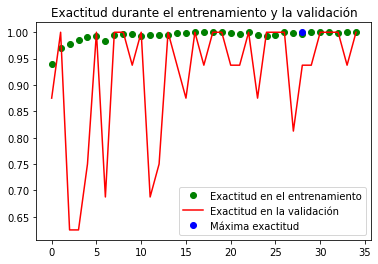

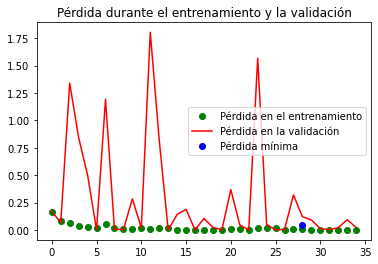

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
max_val_acc2 = max(val_acc)
max_val_acc_epoch2= val_acc.index(max(val_acc)) + 1
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
min_val_loss2 = min(val_loss)
min_val_loss_epoch2= val_loss.index(min(val_loss)) + 1

epochs2 = range(len(acc2))

plt.plot(epochs2, acc2, 'go', label='Exactitud en el entrenamiento')
plt.plot(epochs2, val_acc2, 'r', label='Exactitud en la validación')
plt.plot(max_val_acc_epoch2, max_val_acc2, 'bo', label='Máxima exactitud')
plt.title('Exactitud durante el entrenamiento y la validación')
plt.legend()
plt.figure()

plt.plot(epochs2, loss2, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs2, val_loss2, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch2, min_val_loss2, 'bo', label='Pérdida mínima')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print('Métricas en el conjunto de validación.\n')
print('Pérdida mínima ', min_val_loss2,' fue en la época',min_val_loss_epoch2)
print('Mejor exactitud', max_val_acc2,' fue en la época',max_val_acc_epoch2)
print('\nMétricas en el conjunto de entrenamiento.\n')
print('Pérdida mínima ', min(loss2),' fue en la época',loss2.index(min(loss2)) + 1)
print('Mejor exactitud', max(acc2),' fue en la época',acc2.index(max(acc2)) + 1)

plt.show()

In [ ]:
cm2 = confusion_matrix(y_test, test_predictions)

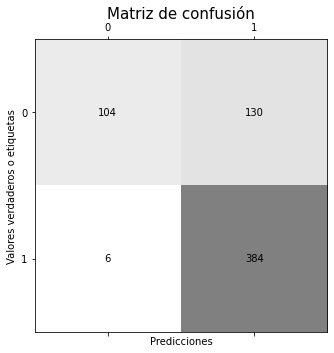

El accuracy obtenido en el conjunto de prueba fue de  0.8237179517745972


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm2, cmap=plt.cm.Greys, alpha=0.5)
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        ax.text(x=j, y=i, s=cm2[i, j], va='center', ha='center')

plt.title("Matriz de confusión", fontsize=15)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos o etiquetas')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()
print('El accuracy obtenido en el conjunto de prueba fue de ',test_acc2)